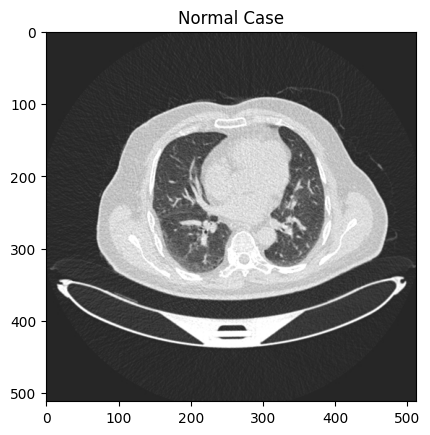

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
img = cv2.imread('/content/.config/Input/Bengin_case/Bengin case (1).jpg')
plt.title('Normal Case')
plt.imshow(img)

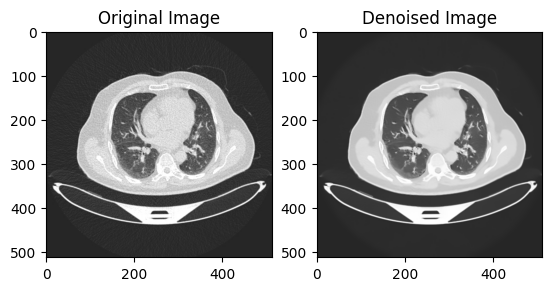

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Reading the noisy image from file
img = cv2.imread('/content/.config/Input/Bengin_case/Bengin case (1).jpg')

# Applying denoising filter
dst = cv2.fastNlMeansDenoising(img, None, 10, 7, 21)

# Displaying original and denoised images
plt.subplot(121), plt.imshow(img), plt.title('Original Image')
plt.subplot(122), plt.imshow(dst), plt.title('Denoised Image')
plt.show()

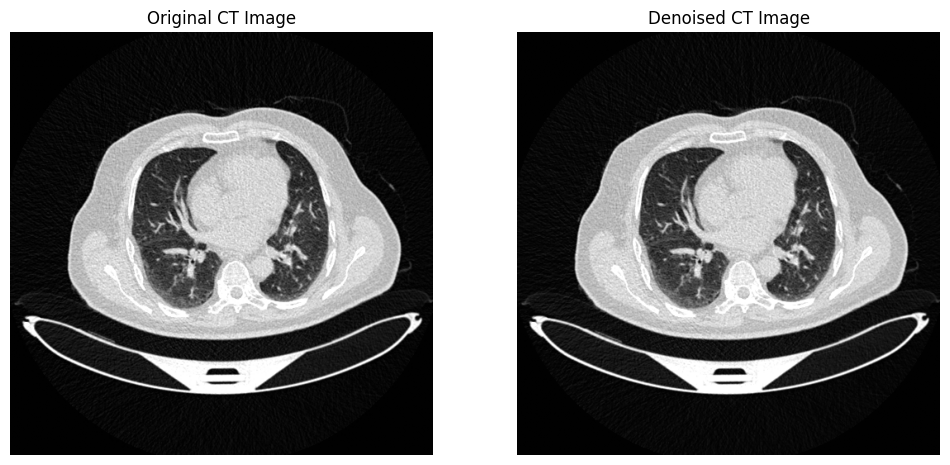

In [ ]:
import pywt
import numpy as np
import cv2
from matplotlib import pyplot as plt

def wavelet_denoise(image, wavelet='db1', level=2, threshold_factor=0.1):
    """
    Perform wavelet-based denoising on a grayscale CT image.
    """
    coeffs = pywt.wavedec2(image, wavelet=wavelet, level=level)
    coeffs_thresholded = [coeffs[0]]  # keep approximation coefficients unchanged

    for detail_level in coeffs[1:]:
        thresholded_detail = []
        for subband in detail_level:
            sigma = np.median(np.abs(subband)) / 0.6745  # noise estimate
            threshold = threshold_factor * sigma
            subband = pywt.threshold(subband, threshold, mode='soft')
            thresholded_detail.append(subband)
        coeffs_thresholded.append(tuple(thresholded_detail))

    denoised_image = pywt.waverec2(coeffs_thresholded, wavelet)
    denoised_image = np.clip(denoised_image, 0, 1)  # keep valid range
    return denoised_image


# ==========================
# Main Code
# ==========================

# Load CT image in grayscale
img = cv2.imread(
    '/content/.config/Input/Bengin_case/Bengin case (1).jpg',
    cv2.IMREAD_GRAYSCALE
)

# Convert to float32 and normalize to [0,1]
img_norm = img.astype(np.float32) / 255.0

# Apply denoising
dimg = wavelet_denoise(img_norm)

# Display
plt.figure(figsize=(12,6))
plt.subplot(1,2,1), plt.imshow(img, cmap='gray'), plt.title('Original CT Image'), plt.axis("off")
plt.subplot(1,2,2), plt.imshow(dimg, cmap='gray'), plt.title('Denoised CT Image'), plt.axis("off")
plt.show()


In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

def compute_wlbp(image, weight_matrix=None, return_hist=False):
    """
    Compute Weighted Local Binary Pattern (WLBP) for a grayscale image.

    Parameters:
    - image: 2D numpy array (grayscale image)
    - weight_matrix: 3x3 numpy array of weights. If None, equal weights are used.
    - return_hist: If True, return normalized histogram (feature vector).
                   If False, return the full WLBP image.

    Returns:
    - wlbp_histogram: Normalized histogram of WLBP patterns (feature vector). [if return_hist=True]
    - wlbp_image: WLBP image (same size as input). [if return_hist=False]
    """

    # Ensure image is float type
    image = image.astype(float)

    # Default weight matrix if none provided
    if weight_matrix is None:
        weight_matrix = np.array([[4, 2, 4],
                                  [2, 0, 2],
                                  [4, 2, 4]])

    # Normalize weight matrix
    weight_matrix = weight_matrix / np.sum(weight_matrix)

    # Output matrix to store WLBP values
    wlbp_image = np.zeros_like(image)

    # Loop over pixels (excluding border)
    for i in range(1, image.shape[0]-1):
        for j in range(1, image.shape[1]-1):
            center = image[i, j]
            weighted_sum = 0
            weight_sum = 0

            # Iterate over 3x3 neighborhood
            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    if dx == 0 and dy == 0:
                        continue  # skip center pixel
                    neighbor = image[i+dx, j+dy]
                    weight = weight_matrix[dx+1, dy+1]
                    weight_sum += weight

                    # Weighted binary pattern (1 if neighbor >= center else 0)
                    bit = 1 if neighbor >= center else 0
                    weighted_sum += bit * weight

            # Assign WLBP value (normalized)
            wlbp_image[i, j] = weighted_sum / weight_sum

    if return_hist:
        # Build histogram (convert WLBP image to histogram feature vector)
        hist, _ = np.histogram(wlbp_image.ravel(), bins=16, range=(0, 1))
        hist = hist.astype(float) / np.sum(hist)  # Normalize histogram
        return hist
    else:
        return wlbp_image


# ---------------- MAIN EXECUTION ----------------

# ✅ Update your image path here
image_path = '/content/.config/Input/Bengin_case/Bengin case (2).jpg'

# Check if image exists
if not os.path.exists(image_path):
    raise FileNotFoundError(f"Image not found at: {image_path}\n"
                            f"Please check the path or upload the file manually.")

# Read the grayscale image
image_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image_gray is None:
    raise ValueError(f"Failed to read image. The file may be corrupted or in an unsupported format: {image_path}")

# Normalize to [0,1]
img_norm = image_gray.astype(np.float32) / 255.0

# Compute WLBP
wlbp_image = compute_wlbp(img_norm)

# Display original and WLBP result
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(image_gray, cmap='gray')
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wlbp_image, cmap='gray')
plt.title('WLBP Features')
plt.axis('off')

plt.show()


FileNotFoundError: Image not found at: /content/.config/Input/Bengin_case/Bengin case (2).jpg
Please check the path or upload the file manually.

[0. 0. 0. ... 0. 0. 0.]


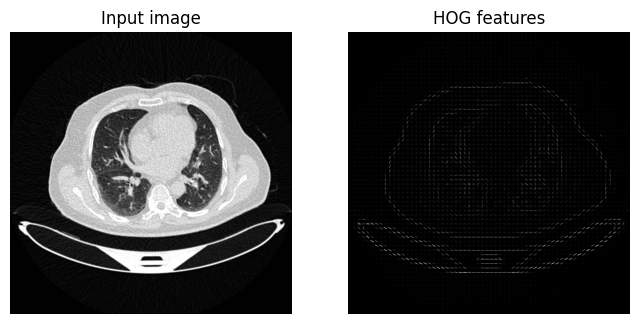

In [ ]:
from skimage import color
from skimage.feature import hog
from skimage import data, exposure, io
import matplotlib.pyplot as plt
import cv2

def extract_hog_features(image_gray):
    """
    Extracts HOG features and the HOG image from a grayscale image.

    Args:
        image_path (str): The path to the image file.

    Returns:
        tuple: A tuple containing:
            - features (ndarray): The HOG features.
            - hog_image (ndarray): The visualized HOG image.
            - image_gray (ndarray): The original grayscale image.
    """


    # Extract HOG features
    features, hog_image = hog(image_gray, orientations=9, pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), visualize=True)

    return features, hog_image

# Example usage:
image_path = '/content/.config/Input/Bengin_case/Bengin case (1).jpg'
image_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
features, hog_image = extract_hog_features(image_gray)

print(features)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(image_gray, cmap='gray')
plt.title('Input image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG features')
plt.axis('off')

plt.show()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Adjust the import path, depending on your version
from skimage.feature import graycomatrix
from skimage.feature.texture import greycoprops


# Load the image as grayscale
img = cv2.imread('/content/.config/Input/Bengin_case/Bengin case (1).jpg',
                 cv2.COLOR_BGR2GRAY)

# Scale and convert image to uint16
img = img.astype(np.float64) # Ensure img is float for scaling
img = 65535 * (img - np.min(img)) / (np.max(img) - np.min(img)) # Scale to 0-65535 for uint16
img = img.astype(np.uint16) # Convert to uint16

# Compute the Gray-Level Co-occurrence Matrix
glcm = graycomatrix(img,
                    distances=[1],
                    angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                    symmetric=True,
                    normed=True,
                    levels=65536) # Explicitly set the number of grey levels for uint16

# Compute texture properties
contrast      = greycoprops(glcm, 'contrast')
energy        = greycoprops(glcm, 'energy')
homogeneity   = greycoprops(glcm, 'homogeneity')
correlation   = greycoprops(glcm, 'correlation')

print("Contrast:\n", contrast)
print("Energy:\n", energy)
print("Homogeneity:\n", homogeneity)
print("Correlation:\n", correlation)

# Visualize the original image
plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='gray')
plt.title('Input Image')
plt.axis('off')
plt.show()

ImportError: cannot import name 'greycoprops' from 'skimage.feature.texture' (/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Adjust the import path, depending on your version
#from skimage.feature import graycomatrix, greycoprops


# Load the image as grayscale
img = cv2.imread('/content/.config/Input/Bengin_case/Bengin case (1).jpg',
                 cv2.IMREAD_GRAYSCALE)
cv2.imshow("image",img)

NameError: name 'cv2_imshow' is not defined

AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, AvgPool2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
img_width = 256
img_height = 256
model = Sequential()
model.add()
model.add(Conv2D(128, (2, 2), padding = 'same', input_shape = (img_height, img_width, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(AvgPool2D(2,2))
model.add(Conv2D(128, (3, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(128, (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(128, (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (3, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(64, (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(3000, activation = 'relu'))
model.add(Dense(1500, activation = 'relu'))
model.add(Dense(3, activation = 'softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
dir = '/content/.config/Input'

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory, img_to_array
train_data = image_dataset_from_directory(dir,label_mode = "categorical", image_size = (img_height, img_width),batch_size = 16, shuffle = True,seed = 12, validation_split = .3, subset = "training")

Found 1097 files belonging to 3 classes.
Using 768 files for training.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

# Train the model
# You might need to adjust the epochs and steps_per_epoch based on your dataset size and desired training time
history = model.fit(train_data, epochs=10)

Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1369s 22s/step - accuracy: 0.5408 - loss: 11.5688
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1388s 22s/step - accuracy: 0.8466 - loss: 0.3916
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1370s 21s/step - accuracy: 0.9255 - loss: 0.2362
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1319s 21s/step - accuracy: 0.9404 - loss: 0.1498
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1332s 21s/step - accuracy: 0.9438 - loss: 0.1589
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1297s 20s/step - accuracy: 0.9709 - loss: 0.0851
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1263s 20s/step - accuracy: 0.9682 - loss: 0.1280
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1232s 20s/step - accuracy: 0.9564 - loss: 0.1088
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1311s 20s/step - accuracy: 0.9736 - loss: 0.0920
Epoch 10/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1327s 21s/step - accuracy: 0.9946 - loss: 0.0088


In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AvgPool2D, Flatten, Dense, Dropout, BatchNormalization, concatenate

def build_dnn_classifier(img_height=256, img_width=256, wlbp_dim=128):
    """
    CNN + WLBP fused DNN for 3-class lung cancer classification.
    """
    # CNN Branch (for CT images)
    cnn_input = Input(shape=(img_height, img_width, 1))  # grayscale
    x = Conv2D(128, (2, 2), padding='same', activation='relu')(cnn_input)
    x = BatchNormalization()(x)
    x = AvgPool2D(2,2)(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2,2)(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    cnn_features = Dense(512, activation='relu')(x)

    # WLBP Branch (handcrafted features)
    wlbp_input = Input(shape=(wlbp_dim,))
    wlbp_features = Dense(256, activation='relu')(wlbp_input)

    # Fusion
    combined = concatenate([cnn_features, wlbp_features])
    y = Dense(3000, activation='relu')(combined)
    y = Dense(1500, activation='relu')(y)
    output = Dense(3, activation='softmax')(y)

    # Build Model
    model1 = Model(inputs=[cnn_input, wlbp_input], outputs=output)
    model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model1


NameError: name 'model1' is not defined